## 1. Сборный проект —2

### Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом (быстро и точно отвечать на вопросы бизнеса): бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. 

Компания предоставила данные с характеристиками сотрудников компании, полученную из форм обратной связи, где указан целевой признак проводимого исследования:
+ 0 — совершенно неудовлетворён
+ 1 — полностью удовлетвоён.

В таблицах данные обозначены:
+ `id` — уникальный идентификатор сотрудника;
+ `dept` — отдел, в котором работает сотрудник;
+ `level` — уровень занимаемой должности;
+ `workload` — уровень загруженности сотрудника;
+ `employment_years` — длительность работы в компании (в годах);
+ `last_year_promo` — показывает, было ли повышение за последний год;
+ `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
+ `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
+ `salary` — ежемесячная зарплата сотрудника;
+ `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.


Разобъём задачу на два этапа:
1. Построим модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика, потому что удовлетворённость работой напрямую влияет на отток сотрудников, а предсказание оттока — одна из важнейших задач HR-аналитиков. 
2. Построим модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

План работы:

1. Построение модели, которая предсказывает уровень удовлетворённости сотрудника в компании
+ 1. Загрузка данных
+ 2. Предобработка данных
+ 3. Исследовательский анализ данных
+ 4. Подготовка данных
+ 5. Обучение моделей
+ 6. Оформление выводов

2. Построение модели, которая предсказывает увольнение сотрудника из компании
+ 1. Загрузка данных
+ 2. Предобработка данных
+ 3. Исследовательский анализ данных
+ 4. Добавление нового входного признака
+ 5. Подготовка данных
+ 6. Обучение модели
+ 7. Выводы

3. Общий вывод

## 2 Предсказание уровня удовлетворённости сотрудника

### 2.1 Загрузка данных

Установка пакетов

In [1]:
!pip install phik -q
!pip install --upgrade scikit-learn==1.3.0 -q
!pip install shap -q

#### 2.1.1 Импорт библиотек

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas  as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import phik
from phik import phik_matrix
import seaborn as sns
import shap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.dummy import (DummyClassifier, 
                           DummyRegressor)
from sklearn.compose import ColumnTransformer
# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer
from sklearn.metrics import (make_scorer, 
                             roc_auc_score)
from sklearn.model_selection import (RandomizedSearchCV,
                                     GridSearchCV)
# загружаем класс pipeline
from sklearn.pipeline import Pipeline
# загружаем классы для подготовки данных
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder, 
                                   OrdinalEncoder,
                                   MinMaxScaler,
                                   RobustScaler,
                                   StandardScaler
                                  )
# загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from scipy. stats import ttest_ind

#### 2.1.2 Загрузка данных

Тренировочная выборка

In [3]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Входные признаки тестовой выборки

In [4]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Целевой признак тестовой выборки

In [5]:
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Данные прочитаны. Прейдем к предобработке.

### 2.2 Предобработка данных

Удаление полных дубликатов при их наличии

In [6]:
train_job_satisfaction_rate.drop_duplicates()
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
test_features.drop_duplicates()
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [8]:
test_target_job_satisfaction_rate.drop_duplicates()
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Проверка сопоставимости данных в `test_features` и `test_target_job_satisfaction_rate`

In [9]:
test_features = pd.merge(test_features, test_target_job_satisfaction_rate, on='id', sort=True)
print(test_features.info())
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.80
1,100480,marketing,junior,low,4,no,no,4,16800,0.84
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79
3,100610,sales,middle,medium,5,no,no,4,43200,0.75
4,100692,sales,middle,high,6,no,no,4,48000,0.69


Таблицы объедены, при этом количество пропусков не увеличилось - данные соответствуют друг другу.

Проверка совпадений в названиях колонок

In [10]:
if list(train_job_satisfaction_rate)==list(test_features):
    print('Полное совпадение названий колонок')
else:
    print('НЕТ совпадения в названиях колонок')

Полное совпадение названий колонок


Проверка перекрестного совпадения значений `id` в тестовой и тренировочной выборке

In [11]:
print('Количество перекрестных совпадений "id" в  таблицах = ', len(train_job_satisfaction_rate[train_job_satisfaction_rate['id'].isin(test_features['id'].unique())]))

Количество перекрестных совпадений "id" в  таблицах =  0


Попарное сравнение данных, замена `' '` на `nan`

In [12]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

In [13]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace('sinior', 'senior')
test_features['level'] = test_features['level'].replace('sinior', 'senior')

In [14]:
for col in train_job_satisfaction_rate.keys().drop(labels=['id', 'salary', 'job_satisfaction_rate']):
    print('Уникальные значения в колонке =', col)
    print(train_job_satisfaction_rate[col].unique())
    print(test_features[col].unique(), '\n-------------')    

Уникальные значения в колонке = dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['hr' 'marketing' 'purchasing' 'sales' 'technology' nan] 
-------------
Уникальные значения в колонке = level
['junior' 'middle' 'senior' nan]
['junior' 'middle' 'senior' nan] 
-------------
Уникальные значения в колонке = workload
['medium' 'high' 'low']
['low' 'high' 'medium' nan] 
-------------
Уникальные значения в колонке = employment_years
[ 2  1  4  7  9  6  3 10  8  5]
[ 2  4  5  6  3  8  1  9  7 10] 
-------------
Уникальные значения в колонке = last_year_promo
['no' 'yes']
['no' 'yes'] 
-------------
Уникальные значения в колонке = last_year_violations
['no' 'yes']
['no' 'yes'] 
-------------
Уникальные значения в колонке = supervisor_evaluation
[1 5 2 3 4]
[4 3 1 2 5] 
-------------


**Промежуточный итог**

Провели предобработку полученных данных:
+ В колонках данные соответствуют типу
+ Дубликаты не обнаружены. 
+ Выявлены пропуски в колонках `dept`и `level`, в колонках train_job_satisfaction_rate['dept'] и test_features['workload'] обнаружены пробелы, проведена замена пробелов `' '` на `np.nan`. 

Проведем в дальнейшем заполнение пропусков в пайплайне при обучении модели с использованием SimpleImputer.

### 2.3 Исследовательский анализ данных
Исследуйте все признаки и сделайте выводы о том, как их нужно подготовить.
 

Исследование числовых показателей

In [15]:
train_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [16]:
test_features.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,552765.213500,3.666500,3.526500,34066.800000,0.54878
std,253851.326129,2.537222,0.996892,15398.436729,0.22011
min,100298.000000,1.000000,1.000000,12000.000000,0.03000
25%,339052.000000,1.000000,3.000000,22800.000000,0.38000
50%,550793.000000,3.000000,4.000000,30000.000000,0.58000
75%,765763.750000,6.000000,4.000000,43200.000000,0.72000
max,999029.000000,10.000000,5.000000,96000.000000,1.00000


Исследование `employment_years`

In [17]:
def f_hist_box(train, test, bins, range, title, xlabel, ylabel):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,5), gridspec_kw={"height_ratios": (.15, .85)})
     
    sns.boxplot(data=[train, test], orient="h", ax=ax_box)
    plt.hist([train, test], 
             bins=bins, range=range, label=['train', 'test'])
 
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [18]:
def f_countplot(train, test, suptitle, xlabel, ylabel):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
    fig.tight_layout(h_pad=3)
    fig.suptitle(suptitle, x=0.5, y=1.07, fontsize=16)
    
    sns.countplot(x=train,ax=ax1)
    sns.countplot(x=test,ax=ax2)
    
    ax1.set_title('Гистограмма категориальной обучающей выборки')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    
    ax2.set_title('Гистограмма категориальной тестовой выборки')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)

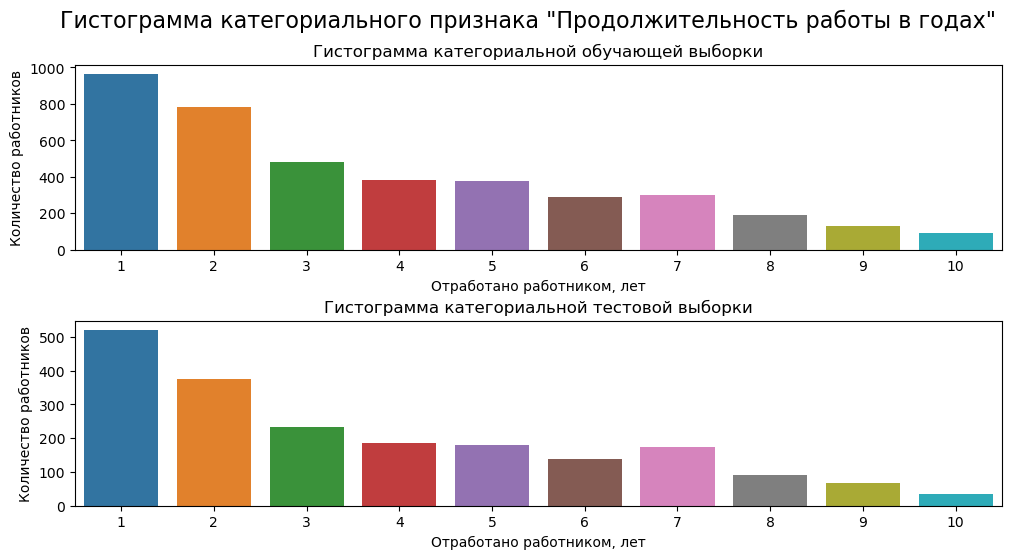

In [19]:
f_countplot(
    train=train_job_satisfaction_rate['employment_years'],
    test=test_features['employment_years'],
    suptitle = 'Гистограмма категориального признака "Продолжительность работы в годах"',
    xlabel='Отработано работником, лет',
    ylabel='Количество работников'
)

Исследование `supervisor_evaluation`

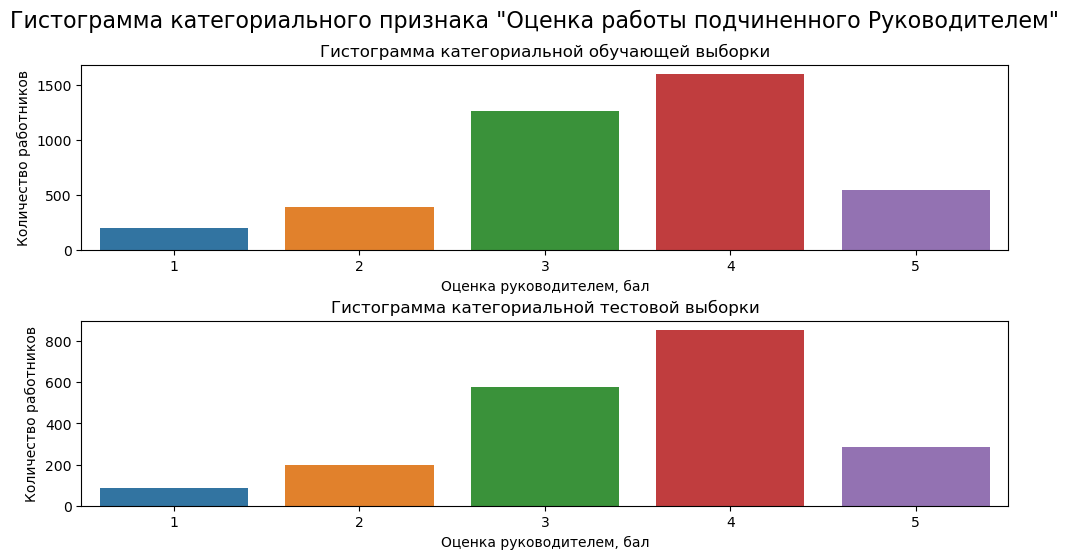

In [20]:
f_countplot(
    train=train_job_satisfaction_rate['supervisor_evaluation'],
    test=test_features['supervisor_evaluation'],
    suptitle = 'Гистограмма категориального признака "Оценка работы подчиненного Руководителем"',
    xlabel='Оценка руководителем, бал',
    ylabel='Количество работников'
)

Исследование `salary`

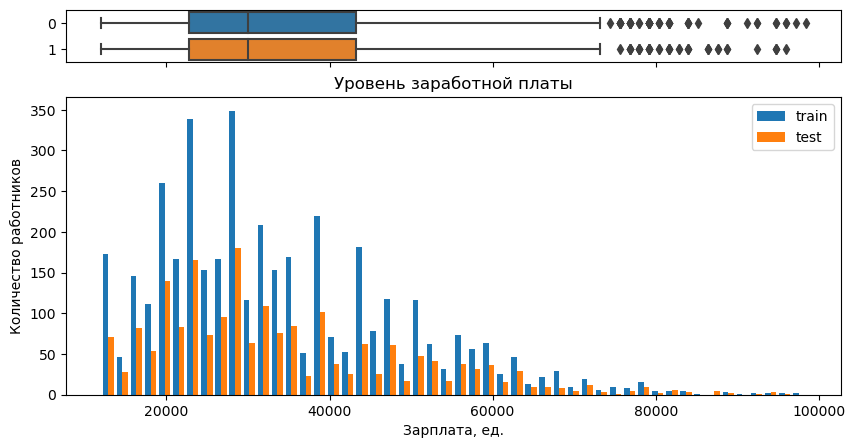

In [21]:
f_hist_box(
    train=train_job_satisfaction_rate['salary'],
    test=test_features['salary'],
    bins=50, 
    range=(train_job_satisfaction_rate['salary'].min(),train_job_satisfaction_rate['salary'].max()),
    title='Уровень заработной платы',
    xlabel='Зарплата, ед.',
    ylabel='Количество работников'
)

Исследование `job_satisfaction_rate`

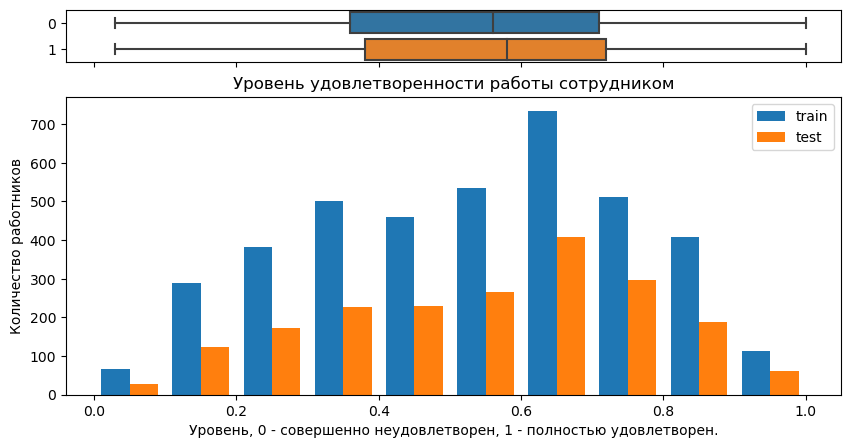

In [22]:
f_hist_box(
    train=train_job_satisfaction_rate['job_satisfaction_rate'],
    test=test_features['job_satisfaction_rate'],
    bins=10, 
    range=(0,1),
    title='Уровень удовлетворенности работы сотрудником',
    xlabel='Уровень, 0 - совершенно неудовлетворен, 1 - полностью удовлетворен.',
    ylabel='Количество работников'
)

Исследование строковых показателей

In [23]:
train_job_satisfaction_rate.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations
count,3994,3996,4000,4000,4000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,1512,1894,2066,3880,3441


In [24]:
test_features.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations
count,1997,1999,1999,2000,2000
unique,5,3,3,2,2
top,sales,junior,medium,no,no
freq,763,974,1043,1937,1738


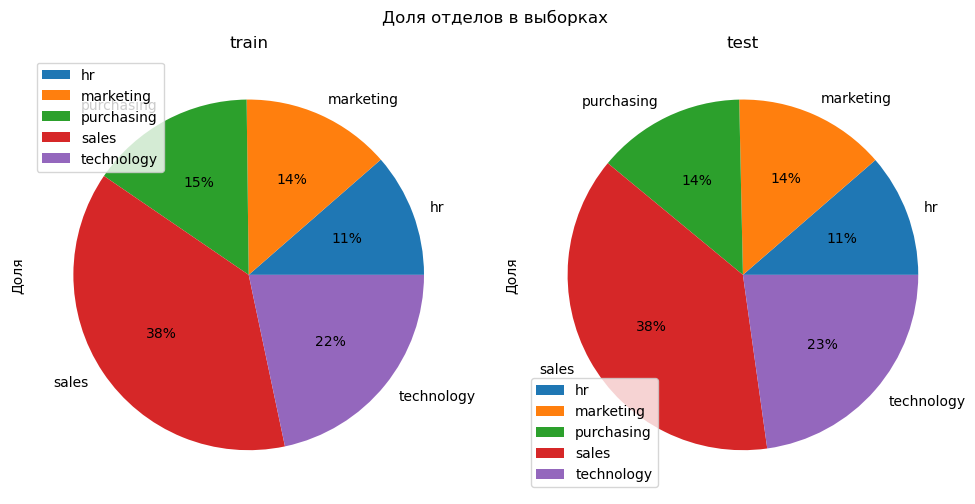

In [25]:
def f_pie_x2(train, test, col, suptitle):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    fig.suptitle(suptitle, x=0.5, y=0.75, fontsize=12)
    
    (
    train
        .pivot_table(index=col,values='id',aggfunc='count')
        .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=ax1, 
                  label='Доля')
    )
    (
    test
        .pivot_table(index=col,values='id',aggfunc='count')
        .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=ax2, 
                  label='Доля')
    )
    ax1.set_title('train')
    ax2.set_title('test')
    plt.tight_layout()
    plt.show()

f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='dept',
         suptitle='Доля отделов в выборках'
)

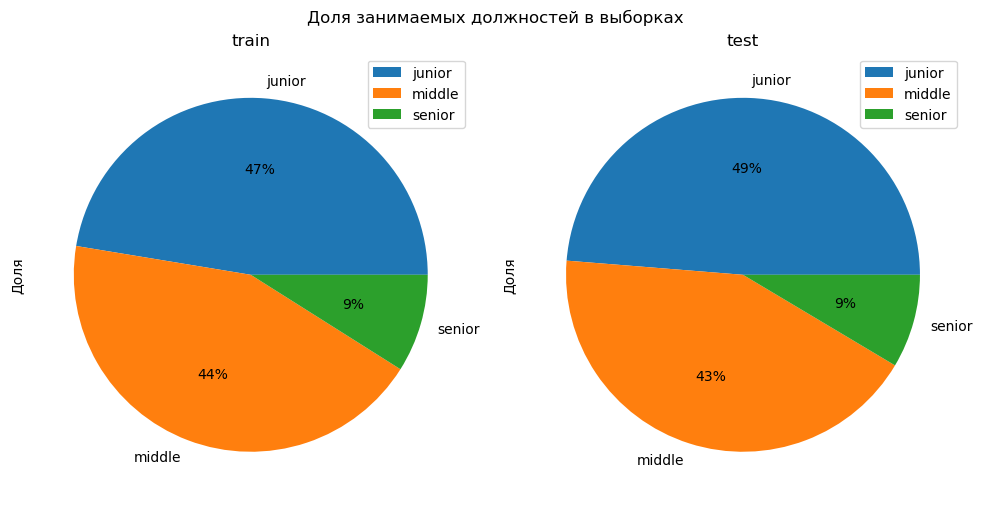

In [26]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='level',
         suptitle='Доля занимаемых должностей в выборках'
)

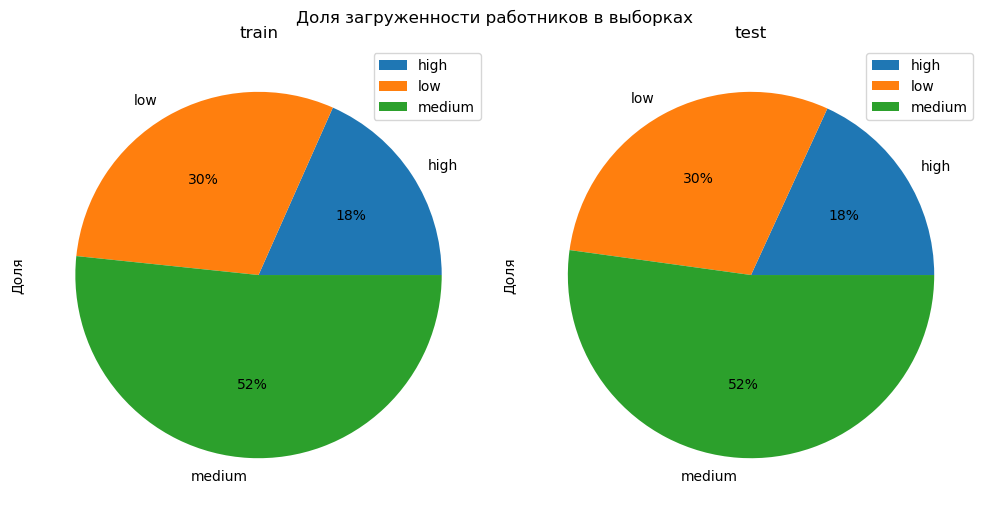

In [27]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='workload',
         suptitle='Доля загруженности работников в выборках'
)

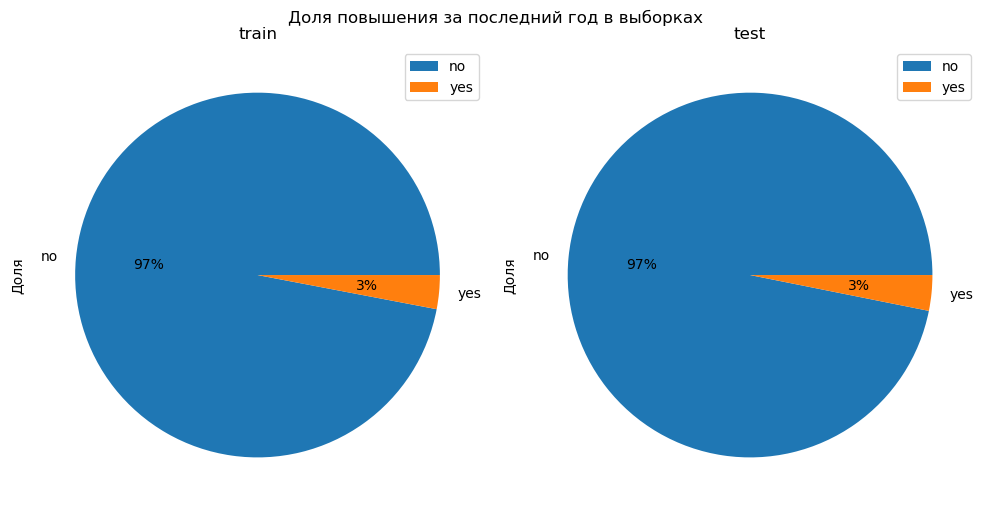

In [28]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='last_year_promo',
         suptitle='Доля повышения за последний год в выборках'
)

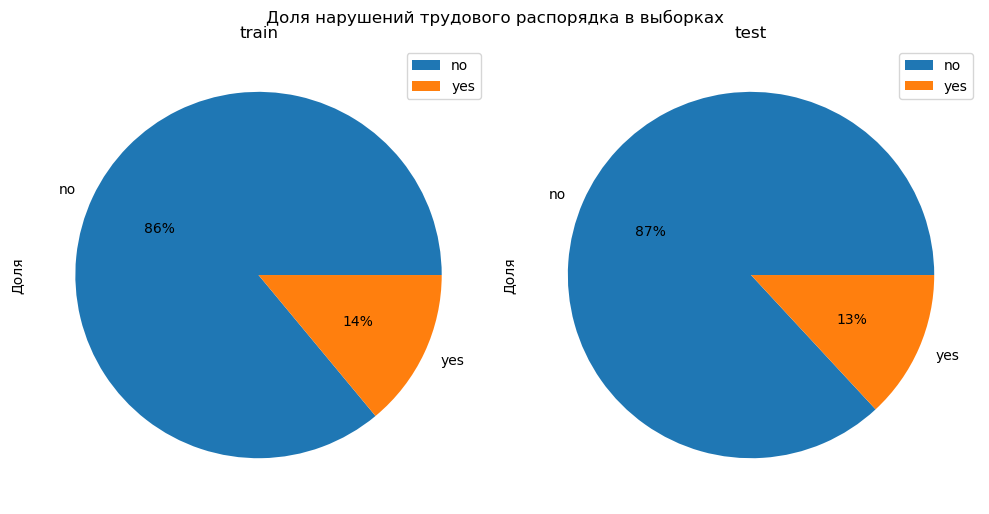

In [29]:
f_pie_x2(train=train_job_satisfaction_rate,
         test=test_features,
         col='last_year_violations',
         suptitle='Доля нарушений трудового распорядка в выборках'
)

Назначим индексом столбец `id`

In [30]:
train_job_satisfaction_rate = train_job_satisfaction_rate.sort_values(by=['id']).set_index('id')
test_features = test_features.sort_values(by=['id']).set_index('id')

Проведем корреляционный анализ данных для исключения мультиколлениарности

Построим матрицу корреляции phi(k) тестовой выборки

In [31]:
interval_cols = ['salary',
                 'job_satisfaction_rate'
                ]

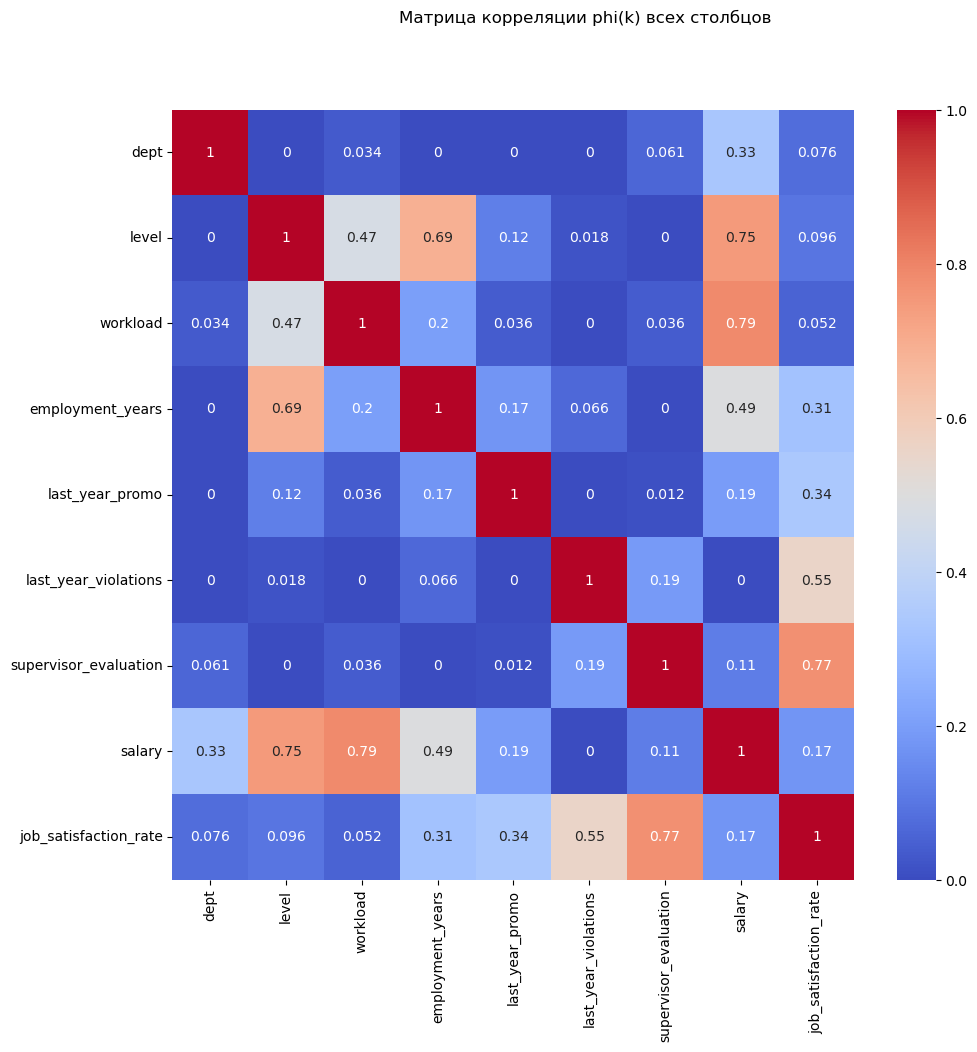

In [32]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(test_features.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Построим матрицу корреляции phi(k) тренировочной выборки

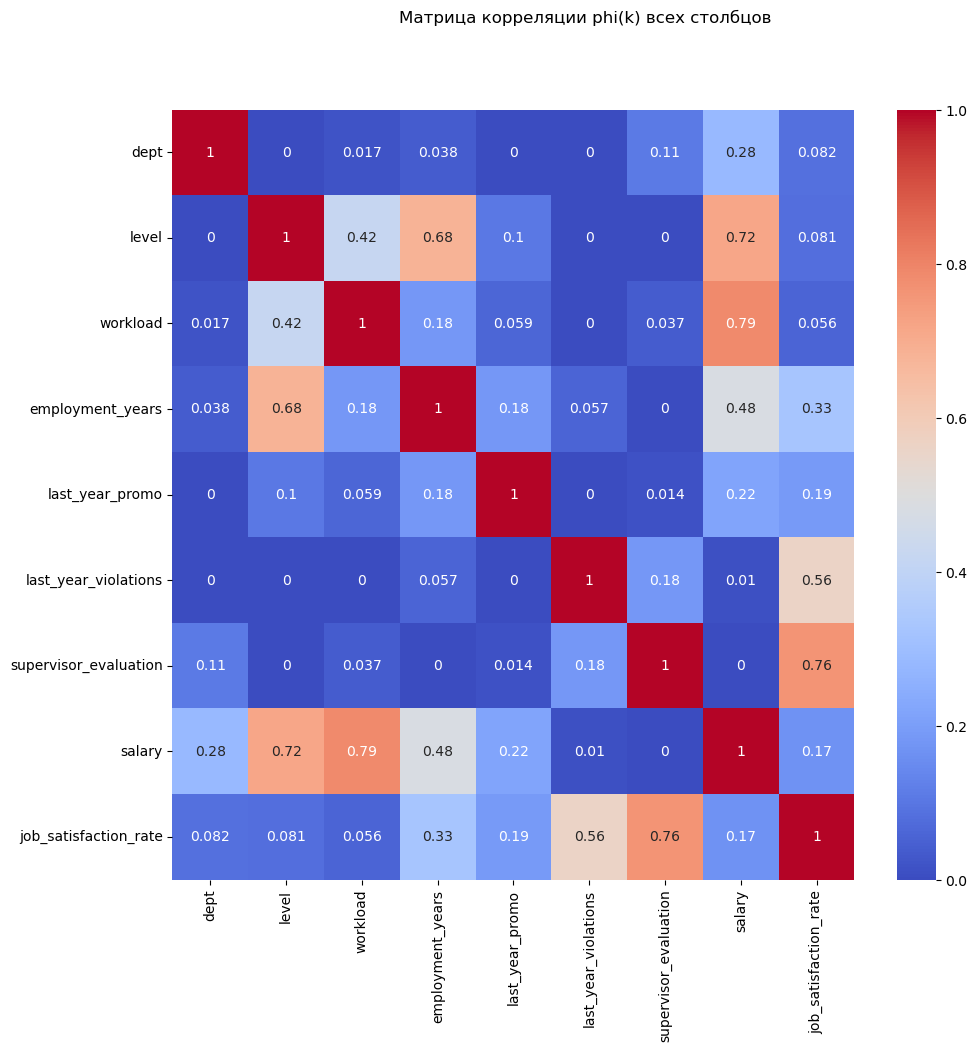

In [33]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(train_job_satisfaction_rate.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

**Промежуточный итог**

Исследовательский анализ данных проведён. Данные id переведены в индекс, отсортированы по возрастанию. Обнаружены выбросы. Связь между входными параметрами отсутствует, выше 0,9. Мультиколлинеарность учитывать не требуется. Корреляция phi(k) равна 0,79 на тренировочной и тестовой выборках. Необходимо заменить пропуски в колонках dept, level, workload. Кодирование признаков dept, last_year_promo, last_year_violations будет выполнено с помощью OneHotEncoder. Кодирование признаков level, workload будет выполнено с помощью OrdinalEncoder. Масштабирование признаков employment_years, supervisor_evaluation, salary будет проведено. Заполнение пропусков, кодирование и масштабирование будут выполнены в пайплайне.

Проведем  заполнение пропусков, кодирование и масштабирование в пайплайне.

### 2.4. Подготовка данных

In [34]:
print(train_job_satisfaction_rate.info(), '\n----------------')
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB
None 
----------------
<class 'pandas.core.frame.DataFrame'>
Index: 3755 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept            

Количество строк в обучающих данных сократилось с 4000 до 3755 после удаления полных дубликатов, что должно положительно сказаться на процессе обучения моделей

In [35]:
RANDOM_STATE = 42

X_train_1 = train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1)
y_train_1 = train_job_satisfaction_rate['job_satisfaction_rate'] 
X_test_1 = test_features.drop('job_satisfaction_rate', axis=1)
y_test_1 = test_features['job_satisfaction_rate']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [36]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

In [37]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [38]:
X_train_1_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train_1), columns=data_preprocessor.get_feature_names_out())
X_test_1_transformed = pd.DataFrame(data_preprocessor.transform(X_test_1), columns=data_preprocessor.get_feature_names_out())

X_train_1_transformed.info(), X_test_1_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ohe__dept_marketing            3755 non-null   float64
 1   ohe__dept_purchasing           3755 non-null   float64
 2   ohe__dept_sales                3755 non-null   float64
 3   ohe__dept_technology           3755 non-null   float64
 4   ohe__last_year_promo_yes       3755 non-null   float64
 5   ohe__last_year_violations_yes  3755 non-null   float64
 6   ord__level                     3755 non-null   float64
 7   ord__workload                  3755 non-null   float64
 8   num__employment_years          3755 non-null   float64
 9   num__supervisor_evaluation     3755 non-null   float64
 10  num__salary                    3755 non-null   float64
dtypes: float64(11)
memory usage: 322.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1

(None, None)

**Промежуточный итог**

В пайплайне данные для обучения модели  подготовлены (информация о DataFreme выше):
+ Заполнены пропуски
+ Проведено кодирование в соответствии с признаками (использовано два кодировщика `ohe - OneHotEncoder`, `ord - OrdinalEncoder`)
+ Проведено масштабирование данных

Проведем обучение моделей на подготовленных данных.

### 2.5. Обучение моделей

Подготовим  целевую функцию SMAPE (англ. symmetric mean absolute percentage error, "симметричное среднее абсолютное процентное отклонение")

In [39]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum( np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2) ) 
   
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

In [40]:
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)], #range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [41]:
rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train_1, y_train_1)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(s...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [DecisionTreeRegressor(max_features=9,
                                                                          random_state=42)],
                                         'models__max_depth': [None, 2, 3, 4, 5,
                                                               6],
                                         'models__max_features': range(2, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False))

In [42]:
print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', rs.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [43]:
print(f'Метрика SMAPE лучшей модели на обучающей выборке: {round(smape(y_train_1, rs.predict(X_train_1)),4)}')

Метрика SMAPE лучшей модели на обучающей выборке: 3.62


In [44]:
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape(y_test_1, rs.predict(X_test_1)),4)}')

Метрика SMAPE лучшей модели на тестовой выборке: 14.7877


Сохнаним все результаты в DataFrame  и отобразим лучшую модель

In [45]:
all_model_1 = pd.DataFrame(rs.cv_results_).sort_values(by=['rank_test_score'])
all_model_1[['rank_test_score',
    'param_models',
    'params'
]].head(1)

,rank_test_score,param_models,params
1,1,"DecisionTreeRegressor(max_features=9, random_state=42)","{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=42)}"


**Промежуточный итог**

Лучшей моделью определена:
+ `DecisionTreeRegressor(max_features=9, random_state=42)`

с параметрами:
+ `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=42)}`

Качество модели удовлетворяет:
Критерию успеха SMAPE ≤ 15 на тестовой выборке: по факту 14.7877

Проверим адекватность модели, сравнив её качество предсказаний с `DummyRegressor` - предсказывает констанстные значения.\
Сравнение проведем на основе целевой функции SMARE

In [46]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train_1, y_train_1)
print(f'Метрика SMAPE модели `DummyRegressor` на обучающей выборке: {round(smape(y_train_1, dummy_regr.predict(X_train_1)),4)}')
print(f'Метрика SMAPE модели `DummyRegressor` на тестовой выборке: {round(smape(y_test_1, dummy_regr.predict(X_test_1)),4)}')

Метрика SMAPE модели `DummyRegressor` на обучающей выборке: 39.9483
Метрика SMAPE модели `DummyRegressor` на тестовой выборке: 37.7728


### 2.6. Оформление выводов

**Промежуточный итог**

В процессе обучения моделей и подбора параметров работа производилась для LinearRegression() и DecisionTreeRegressor(). В процессе работы была отобрана лучшая модель DecisionTreeRegressor(max_features=9, random_state=42) с параметрами {'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=42)}. Отбор модели производился по целевой функции SMAPE (англ. symmetric mean absolute percentage error, "симметричное среднее абсолютное процентное отклонение"). Качество лучшей модели удовлетворяет критерию успеха SMAPE ≤ 15 на тестовой выборке, фактическое значение составляет 14.7877. Модель LinearRegression() хуже справилась с задачей, потому что матрица корреляции показывает отсутствие явной линейной зависимости между входными и целевыми показателями (максимальное значение phi(k) = 0,79). Кроме того, DecisionTreeRegressor() успешно подстроилась между входными и целевыми параметрами во время обучения.

## 3 Предсказание увольнения сотрудника из компании

### 3.1 Загрузка данных

In [47]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [48]:
try:
    test_features_2 = pd.read_csv('/datasets/test_features.csv')
except:
    test_features_2 = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_features_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [49]:
try:
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Данные прочитаны. Прейдем к предобработке.

### 3.2 Предобработка данных

Удаление полных дубликатов при их наличии

In [50]:
train_quit.drop_duplicates()
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [51]:
test_features_2.drop_duplicates()
test_features_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [52]:
test_target_quit.drop_duplicates()
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Проверка сопоставимости данных в `test_features` и `test_target_quit`

In [53]:
test_features_2 = pd.merge(test_features_2, test_target_quit, on='id', sort=True)
print(test_features_2.info())
test_features_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 156.4+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,100298,hr,junior,low,2,no,no,4,19200,no
1,100480,marketing,junior,low,4,no,no,4,16800,no
2,100503,purchasing,middle,high,5,no,no,4,55200,no
3,100610,sales,middle,medium,5,no,no,4,43200,no
4,100692,sales,middle,high,6,no,no,4,48000,no


Таблицы объедены, при этом количество пропусков не увеличилось - данные соответствуют друг другу.

Проверка совпадений в названиях колонок

In [54]:
if list(train_quit)==list(test_features_2):
    print('Полное совпадение названий колонок')
else:
    print('НЕТ совпадения в названиях колонок')

Полное совпадение названий колонок


Проверка перекрестного совпадения значений `id` в тестовой и тренировочной выборке

In [55]:
print('Количество перекрестных совпадений "id" в  таблицах = ', len(train_quit[train_quit['id'].isin(test_features_2['id'].unique())]))

Количество перекрестных совпадений "id" в  таблицах =  0


Попарное сравнение данных, замена `' '` на `nan`

In [56]:
test_features_2['dept'] = test_features_2['dept'].replace(' ', np.nan)
test_features_2['workload'] = test_features_2['workload'].replace(' ', np.nan)
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
test_features_2['level'] = test_features_2['level'].replace('sinior', 'senior')
for col in train_quit.keys().drop(labels=['id']):
    print('Уникальные значения в колонке =', col)
    print(train_quit[col].unique())
    print(test_features_2[col].unique(), '\n-------------')   

Уникальные значения в колонке = dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']
['hr' 'marketing' 'purchasing' 'sales' 'technology' nan] 
-------------
Уникальные значения в колонке = level
['middle' 'junior' 'senior']
['junior' 'middle' 'senior' nan] 
-------------
Уникальные значения в колонке = workload
['high' 'medium' 'low']
['low' 'high' 'medium' nan] 
-------------
Уникальные значения в колонке = employment_years
[ 2  5  1  8  4  7  3  9  6 10]
[ 2  4  5  6  3  8  1  9  7 10] 
-------------
Уникальные значения в колонке = last_year_promo
['no' 'yes']
['no' 'yes'] 
-------------
Уникальные значения в колонке = last_year_violations
['no' 'yes']
['no' 'yes'] 
-------------
Уникальные значения в колонке = supervisor_evaluation
[4 1 3 5 2]
[4 3 1 2 5] 
-------------
Уникальные значения в колонке = salary
[54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 5

**Промежуточный итог**

Провели предобработку полученных данных:
+ В колонках данные соответствуют типу
+ Дубликаты не обнаружены. 
+ Выявлены пропуски в колонках `dept`и `level`, в колонках `test_features['dept']` и `test_features['workload']` обнаружены пробелы, проведена замена пробелов `' '` на `np.nan`. 

Проведем в дальнейшем заполнение пропусков в пайплайне при обучении модели с использованием SimpleImputer.

### 3.3 Исследовательский анализ данных

#### 3.3.1. Исследовательский анализ данных.

Исследование числовых показателей

In [57]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [58]:
test_features_2.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Исследование `employment_years`

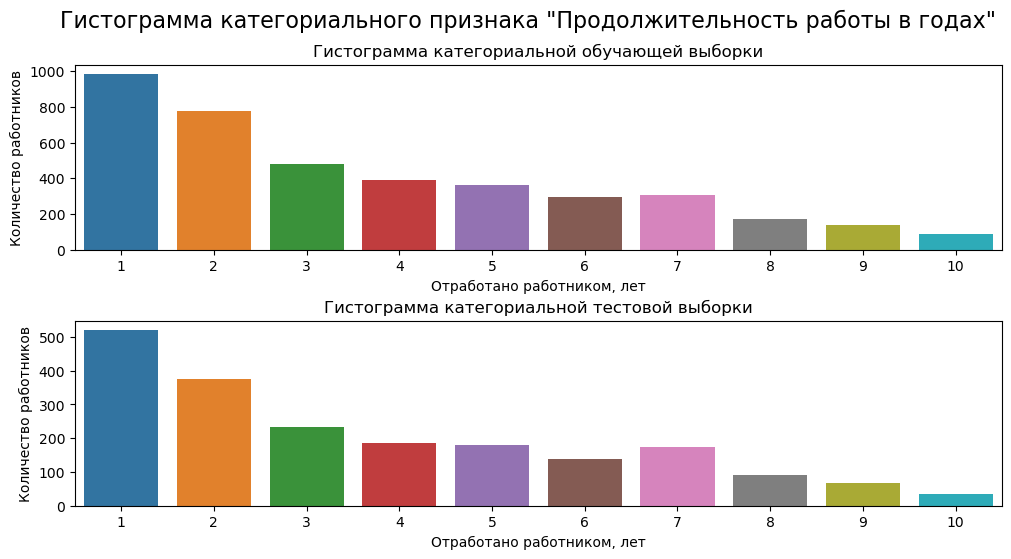

In [59]:
f_countplot(
    train=train_quit['employment_years'],
    test=test_features_2['employment_years'],
    suptitle = 'Гистограмма категориального признака "Продолжительность работы в годах"',
    xlabel='Отработано работником, лет',
    ylabel='Количество работников'
)

Исследование `supervisor_evaluation`

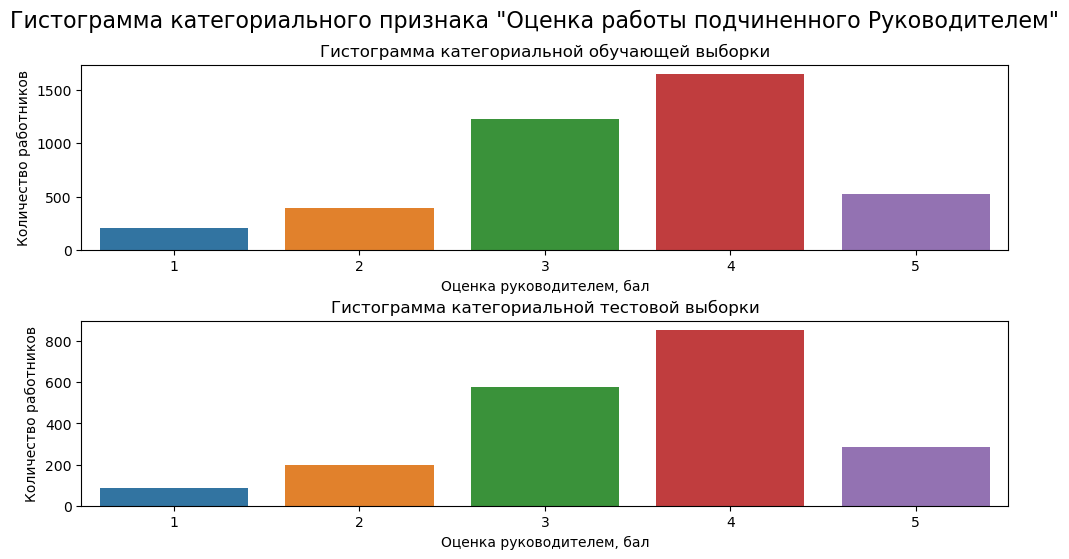

In [60]:
f_countplot(
    train=train_quit['supervisor_evaluation'],
    test=test_features_2['supervisor_evaluation'],
    suptitle = 'Гистограмма категориального признака "Оценка работы подчиненного Руководителем"',
    xlabel='Оценка руководителем, бал',
    ylabel='Количество работников'
)

Исследование `salary`

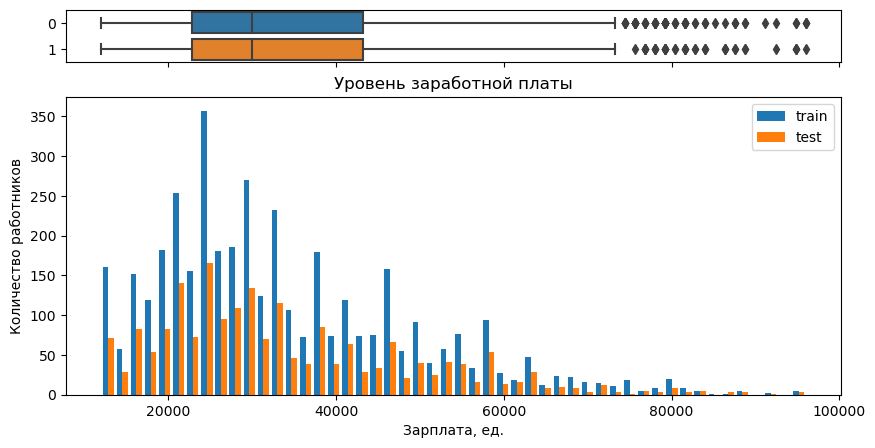

In [61]:
f_hist_box(
    train=train_quit['salary'],
    test=test_features_2['salary'],
    bins=50,
    range=(train_quit['salary'].min(),train_quit['salary'].max()),
    title='Уровень заработной платы',
    xlabel='Зарплата, ед.',
    ylabel='Количество работников'
)

Исследование строковых показателей

In [62]:
train_quit.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations,quit
count,4000,4000,4000,4000,4000,4000
unique,5,3,3,2,2,2
top,sales,junior,medium,no,no,no
freq,1438,1949,2118,3887,3455,2872


In [63]:
test_features_2.describe(include='object')

,dept,level,workload,last_year_promo,last_year_violations,quit
count,1997,1999,1999,2000,2000,2000
unique,5,3,3,2,2,2
top,sales,junior,medium,no,no,no
freq,763,974,1043,1937,1738,1436


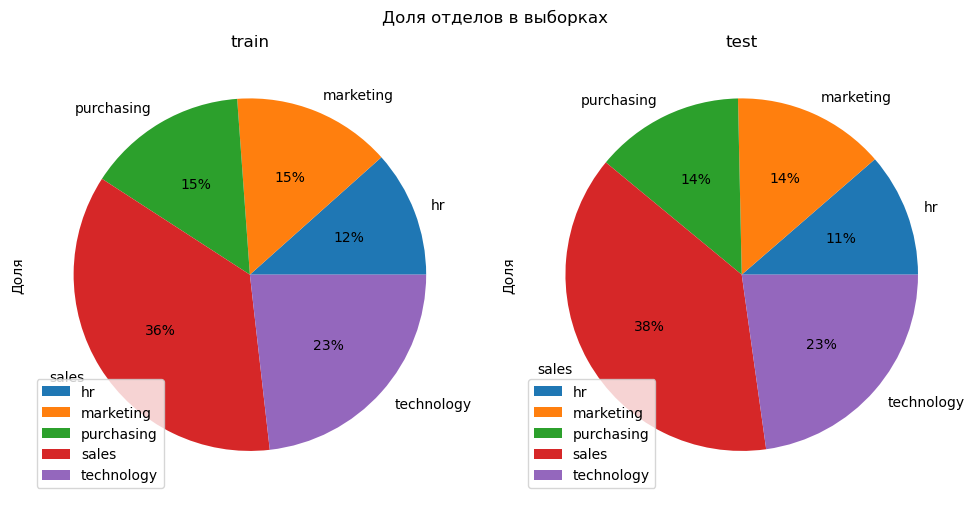

In [64]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='dept',
         suptitle='Доля отделов в выборках'
)

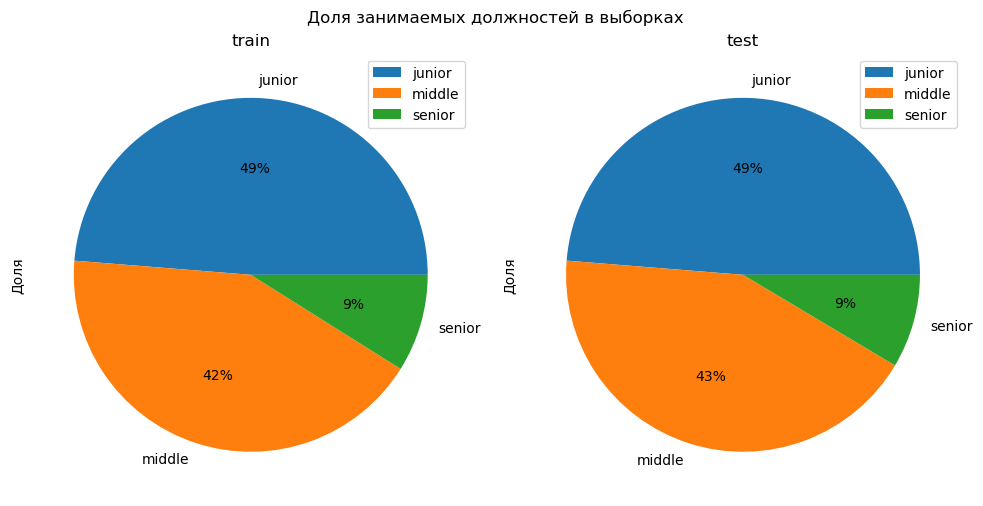

In [65]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='level',
         suptitle='Доля занимаемых должностей в выборках'
)

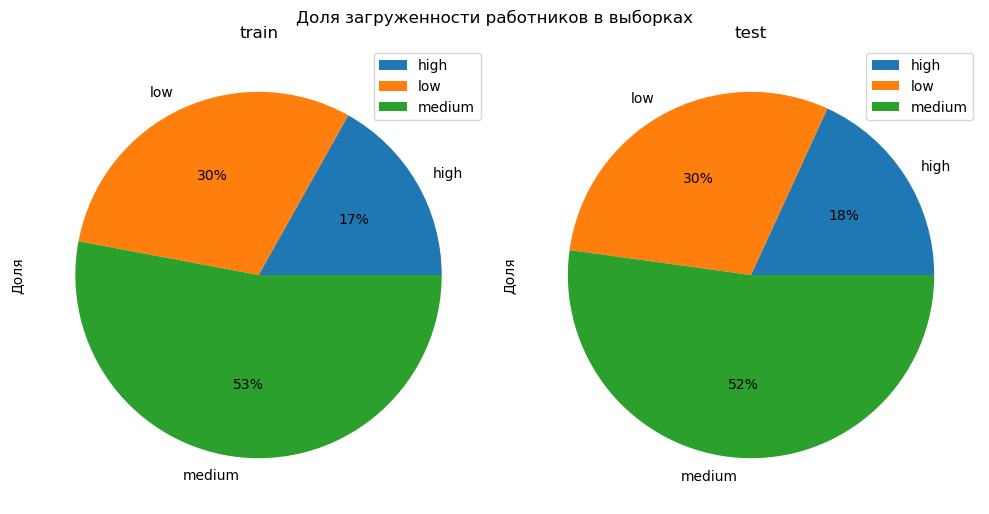

In [66]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='workload',
         suptitle='Доля загруженности работников в выборках'
)

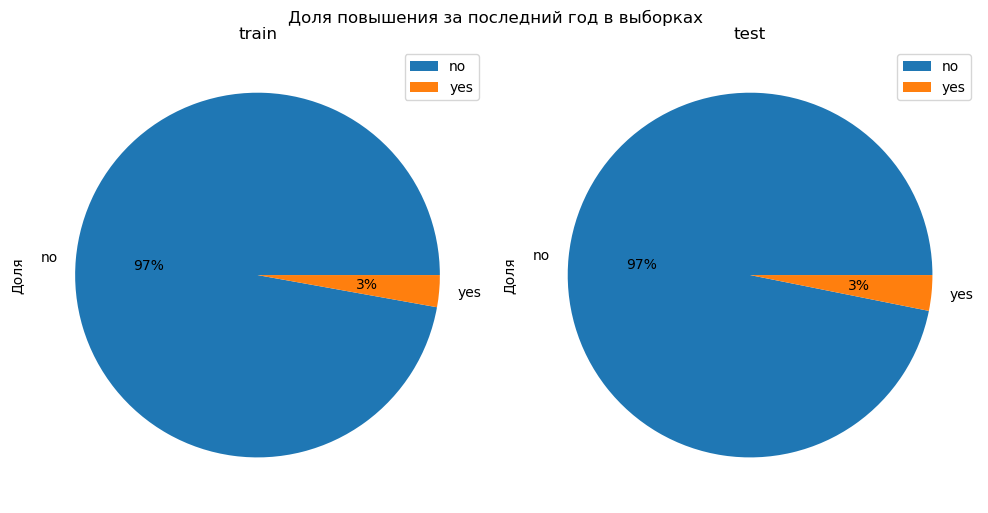

In [67]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='last_year_promo',
         suptitle='Доля повышения за последний год в выборках'
)

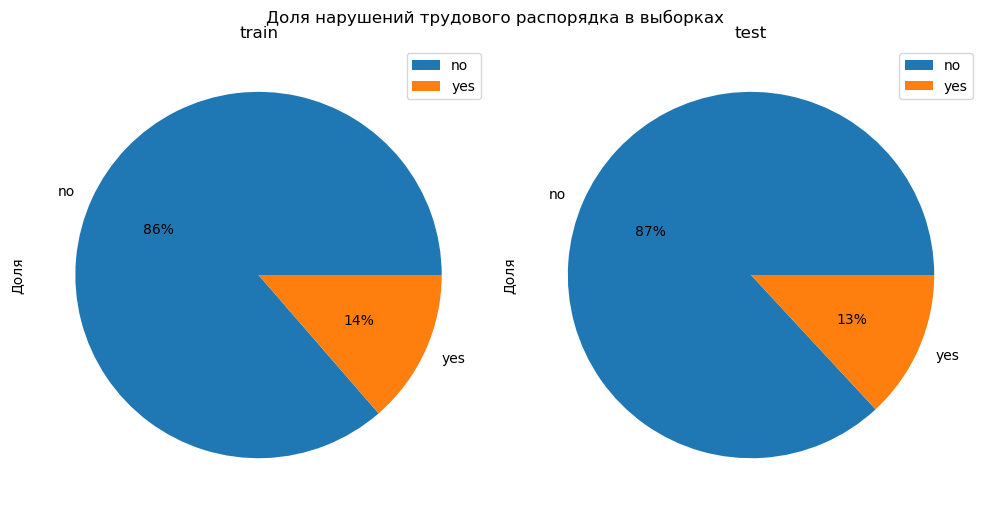

In [68]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='last_year_violations',
         suptitle='Доля нарушений трудового распорядка в выборках'
)

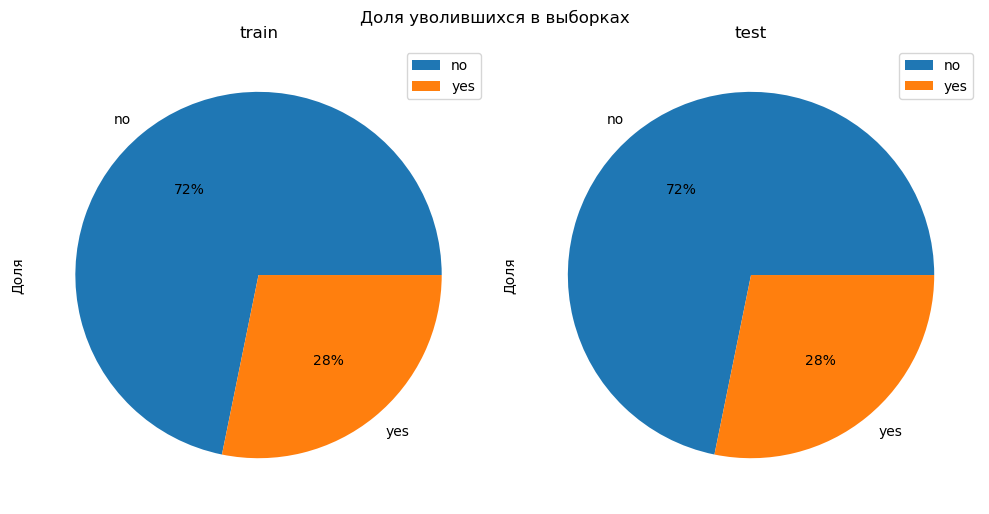

In [69]:
f_pie_x2(train=train_quit,
         test=test_features_2,
         col='quit',
         suptitle='Доля уволившихся в выборках'
)

**Промежуточный итог**

Провели исследовательский анализ данных:
+ данные `id`, переведены в индекс, отсортированы по возрастающему 
+ в данных обнаружены выбросы
+ В колонках `dept`, `level`, `workload` необходимо заменить пропуски, предпочтительно на часто встречающееся
+ Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью OneHotEncoder.
+ Два признака: `level`, `workload` — нужно кодировать с помощью OrdinalEncoder.
+ Три признака: `employment_years`, `supervisor_evaluation`, `salary` - необходимо масштабировать.
+ Целевой признак перевести в числовым значениям 1 - yes - уволился, 0 - no - работает

Проведем  заполнение пропусков, кодирование и масштабирование в пайплайне.

#### 3.3.2. Составим портрет «уволившегося сотрудника».

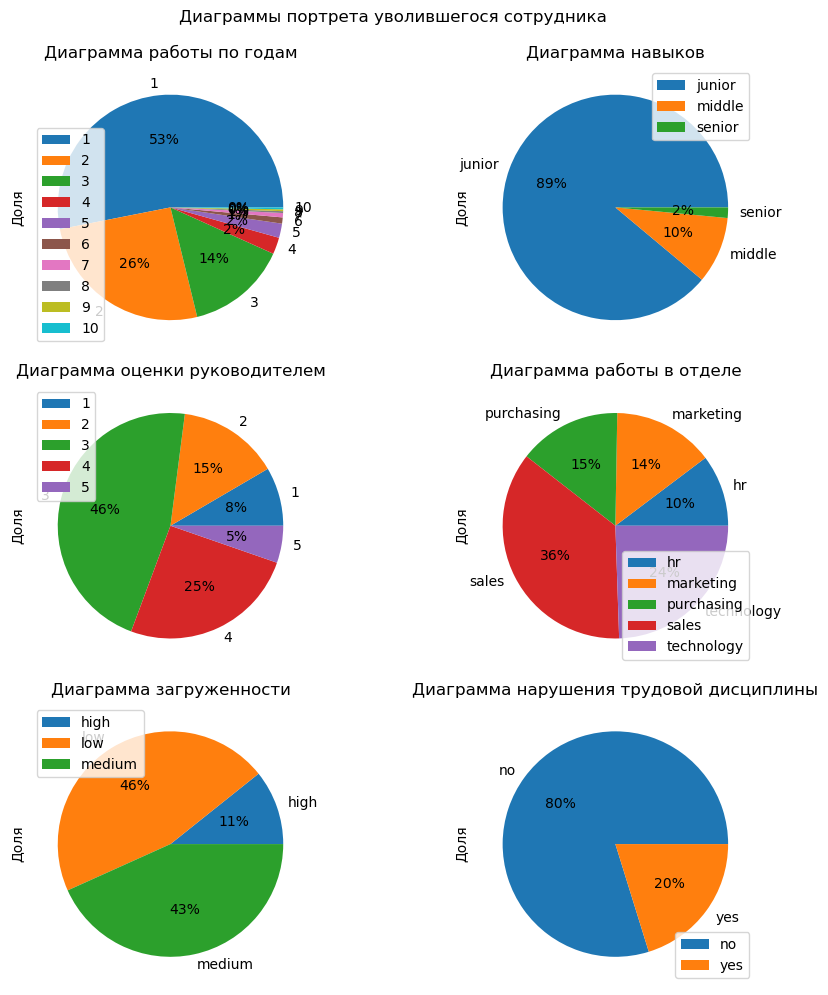

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 5))
fig.suptitle('Диаграммы портрета уволившегося сотрудника', x=0.5, y=0.99, fontsize=12)

(
train_quit.query('quit == "yes"') 
.pivot_table(index='employment_years',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[0,0], 
label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='level',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[0,1], 
label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='supervisor_evaluation',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[1,0], 
label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='dept',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[1,1], 
label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='workload',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[2,0], 
label='Доля')
)
(
train_quit.query('quit == "yes"') 
.pivot_table(index='last_year_violations',values='id',aggfunc='count')
.plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), ax=axes[2,1], 
label='Доля')
)

axes[0,0].set_title('Диаграмма работы по годам')
axes[0,1].set_title('Диаграмма навыков')
axes[1,0].set_title('Диаграмма оценки руководителем')
axes[1,1].set_title('Диаграмма работы в отделе')
axes[2,0].set_title('Диаграмма загруженности')
axes[2,1].set_title('Диаграмма нарушения трудовой дисциплины')
plt.tight_layout()
plt.show()

In [71]:
train_quit.pivot_table(index = 'quit', values = 'salary', aggfunc = 'median')

,salary
quit,
no,34800
yes,22800


**Промежуточный итог**

Определен портрет уволивщегося сотрудника:
+ Начинающий сотрудник (отработал всего год) с вероятностью 53% 
+ Навыки работы - junior с вероятностью 89%
+ Оценен непосредственным руководителем на 3 по 5 бальной шкале с вероятностью 46%
+ Является сотрудником отдела Sales с вероятностью 36%, отдела Technology - 24%
+ Загрузка сотрудника Low с вероятностью 46% и Medium - 43%
+ В течении года нарушал трудовую дисциплину с вероятностью 20%
+ Медианная заработная плата составляет 22800, в то время как продолживших работать 34800

#### 3.3.3. Проверка влияния уровеня удовлетворённости сотрудника работой на увольнение сотрудника.


Проведем объединение целевых признаков по `id`

In [72]:
p_df = pd.merge(test_target_quit, test_target_job_satisfaction_rate, on='id', sort=True).sort_values(by='id')

Построим `гистограмму` и `boxplot` целевых признаков

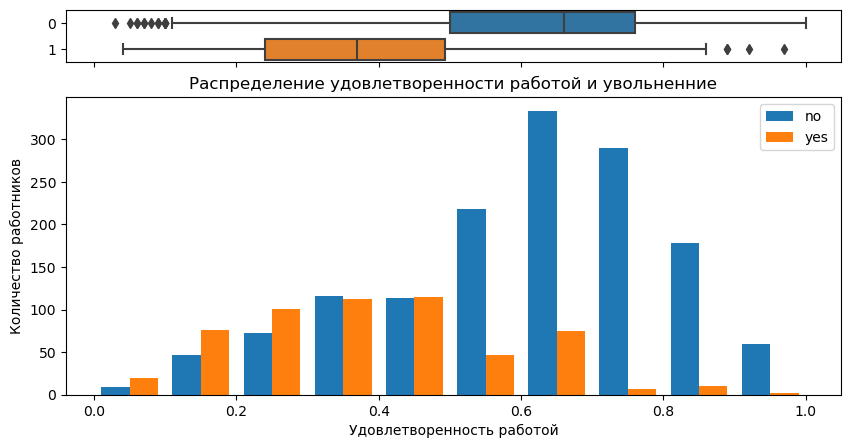

In [73]:
col = 'job_satisfaction_rate'
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,5), gridspec_kw={"height_ratios": (.15, .85)})
 
sns.boxplot(data=[p_df[p_df['quit']=='no'][col], p_df[p_df['quit']=='yes'][col]], orient="h", ax=ax_box)
plt.hist([p_df[p_df['quit']=='no'][col], p_df[p_df['quit']=='yes'][col]], 
         bins=10, range=(0,1), label=['no', 'yes'])

plt.legend(loc='upper right')
plt.title('Распределение удовлетворенности работой и увольненние')
plt.xlabel('Удовлетворенность работой')
plt.ylabel('Количество работников')
plt.show()

Построим Плотность распределения (KDE) коэффициента удовлетворенности работой

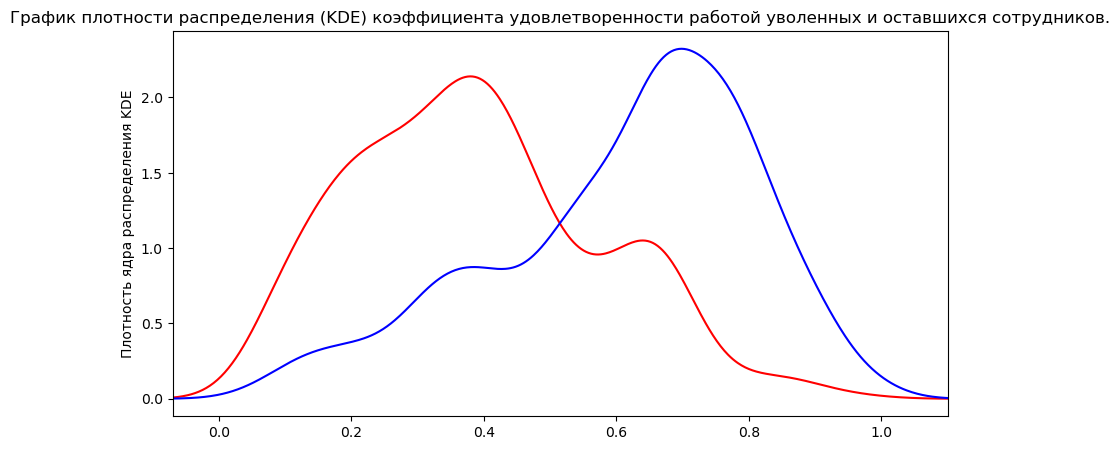

In [74]:
plt.figure(figsize=(10,5))
plt.title('График плотности распределения (KDE) коэффициента удовлетворенности работой уволенных и оставшихся сотрудников.')
plt.xlim (p_df['job_satisfaction_rate'].min()-0.1, p_df['job_satisfaction_rate'].max()+0.1)
ax = p_df[p_df['quit']=='yes']['job_satisfaction_rate'].plot.kde(color='red')
ax = p_df[p_df['quit']=='no']['job_satisfaction_rate'].plot.kde(color='blue')
ax.set_ylabel('Плотность ядра распределения KDE')
plt.show()

**Промежуточный итог**

Построенные гистограммы с боксплотами, плотности распределения удовлетворенности работой, указывает на связь с увольнением сотрудников. В общем случае можно указать, что увольняются работники, которые неудовлетворены работой.

Выдвенем гипотезы:\
H0: Средние значения совокупной выборки равны, а значит зависимости между увольнением и удовлетворенностью работой нет.\
H1: Средние значения совокупной выборки не равны, а значит есть зависимости между увольнением и удовлетворенностью работой.

In [75]:
group1 = p_df[p_df['quit']=='yes']
group2 = p_df[p_df['quit']=='no']

# Независимый двухвыборочный t-критерий используется, чтобы определить, равны ли два средних значения совокупности
print(ttest_ind(group1['job_satisfaction_rate'], group2['job_satisfaction_rate']))
# Стьюдент-критерий Уэлча аналогичен независимому t-тесту для двух выборок, 
# за исключением того, что он не предполагает, что две совокупности, 
# из которых взяты выборки, имеют одинаковую дисперсию .
print(ttest_ind(group1['job_satisfaction_rate'], group2['job_satisfaction_rate'], equal_var= False ))


TtestResult(statistic=-23.074784903634534, pvalue=1.231122066517193e-104, df=1998.0)
TtestResult(statistic=-23.795097591114747, pvalue=2.7708628031539788e-101, df=1099.2247109659888)


**Промежуточный итог**

Поскольку p-значение меньше 0,05, мы отклоняем нулевую гипотезу t-критерия и делаем вывод, что имеется достаточно доказательств того, что средние значения генеральной совокупности не равны, а следовательно есть зависимость между увольнением и неудовлетворенностью работой

### 3.4. Добавление нового входного признака

Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи

In [76]:
train_quit['job_satisfaction_rate'] = rs.predict(train_quit)
test_features_2['job_satisfaction_rate'] = rs.predict(test_features_2)
train_quit.info(), test_features_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   quit                   4000 non-null   object 
 10  job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dt

(None, None)

Дополнение таблиц новыми данными прошло успешно, пропуски в новых данных отсутствуют, проверим корреляционную взаимосвяз данных

Назначим индексом столбец `id`

In [77]:
train_quit = train_quit.sort_values(by=['id']).set_index('id')
test_features_2 = test_features_2.sort_values(by=['id']).set_index('id')

Удалим полные дубликаты в тренировочной выборке после назначения `id` индексом, это должно положительно повлиять на процес обучения моделей

In [78]:
print(train_quit.info(), '\n----------------')
train_quit = train_quit.drop_duplicates()
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   4000 non-null   object 
 1   level                  4000 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   quit                   4000 non-null   object 
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 343.8+ KB
None 
----------------
<class 'pandas.core.frame.DataFrame'>
Index: 2587 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------        

После удаления полных дубликатов обучающая выборка сократилась с 4000 строк до 2587

Построим матрицу корреляции phi(k) тренировочной выборки

In [79]:
interval_cols = ['salary',
                 'job_satisfaction_rate'
                ]

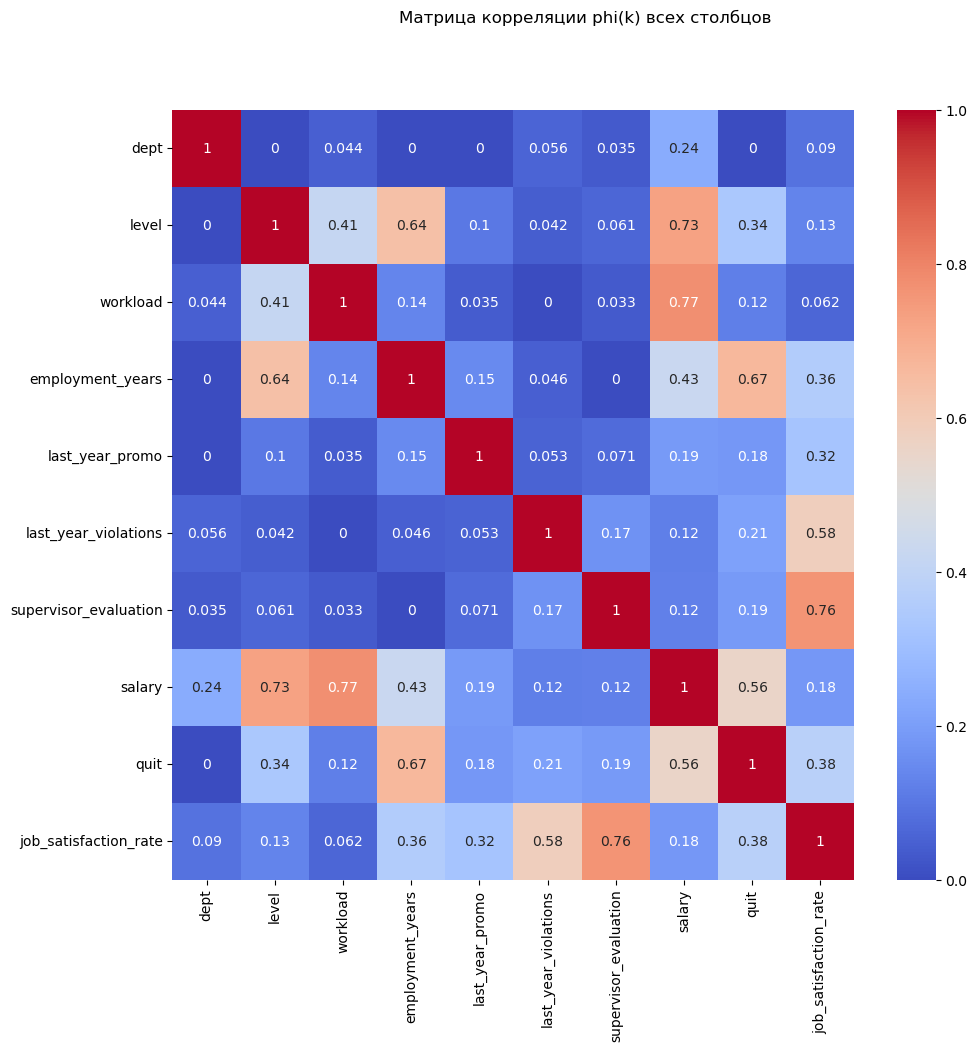

In [80]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(train_quit.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Построим матрицу корреляции phi(k) тестовой выборки

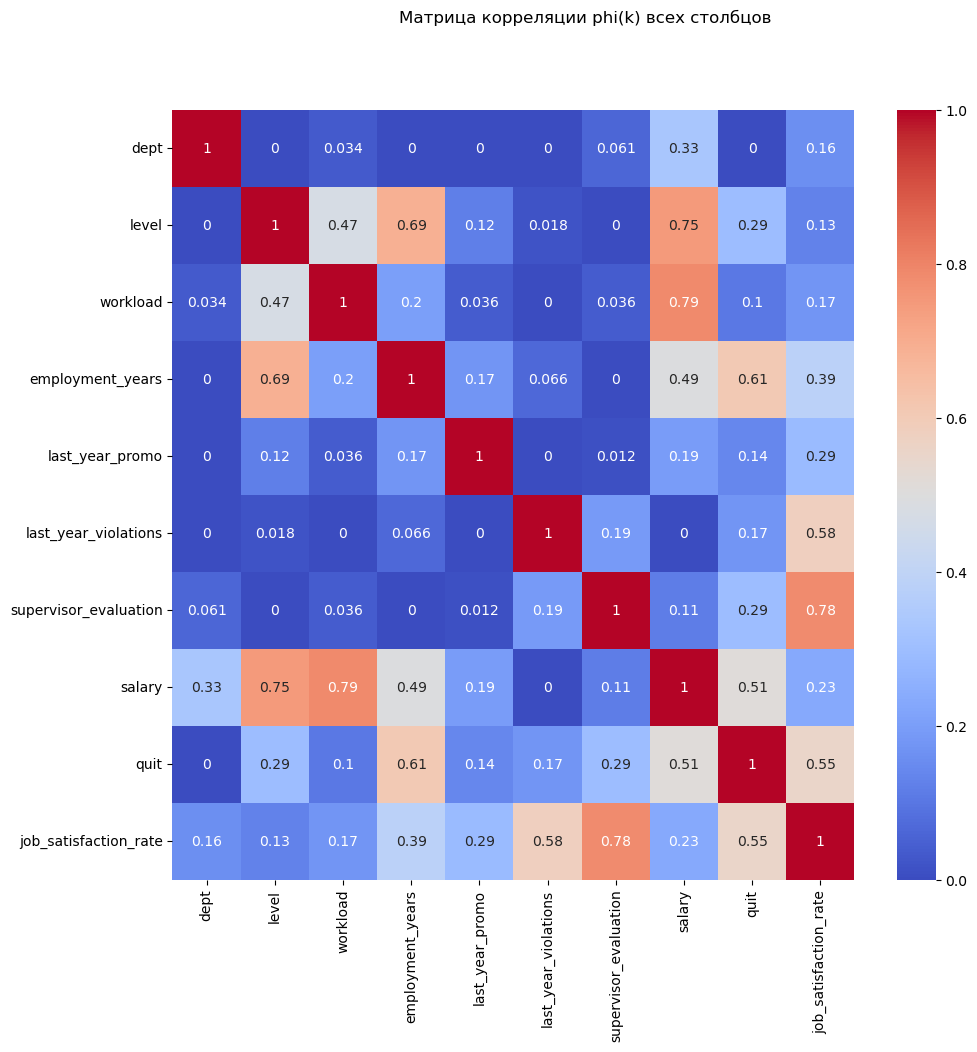

In [81]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(test_features_2.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

**Промежуточный итог**

Провели исследовательский анализ данных:
+ данные `id`, переведены в индекс, отсортированы по возрастающему 
+ в данных обнаружены выбросы
+ Между входными параметрами отсутствует связь выше 0,9 следовательно при обучении модели учитывать мультиколлинеарность не надо (максимальное значение корреляция phi(k) (учитывает нелинейную зависимость и возвращается к коэффициенту корреляции Пирсона в случае бинарного нормального распределения входных данных) phi(k) = 0,79, на тренировочной и тестовой выборках, значения корреляции немного разнятся, но общая оценка - соответствуют друг другу
+ к исходным данным добавлен уровень удовлетворенности работой `job_satisfaction_rate` полученный на основе лучшей модели
+ В колонках `dept`, `level`, `workload` необходимо заменить пропуски, предпочтительно на часто встречающееся
+ Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью OneHotEncoder.
+ Два признака: `level`, `workload` — нужно кодировать с помощью OrdinalEncoder.
+ Четыре признака: `employment_years`, `supervisor_evaluation`, `salary`, `job_satisfaction_rate`- достаточно масштабировать.

Проведем  заполнение пропусков, кодирование и масштабирование в пайплайне.

### 3.5 Подготовка данных


К подготовке данных к обучению модели добавляется признак `job_satisfaction_rate`, он содержит числовые значения и подлежит масштабированию, `ohe_columns` `ord_columns` без изменений

In [82]:
le = LabelEncoder()
le.fit_transform(train_quit['quit'].unique())
print ('Значениям', le.classes_, 'назначено соответственно', le.transform(le.classes_))
train_quit['quit'] = le.transform(train_quit['quit'])
test_features_2['quit'] = le.transform(test_features_2['quit'])

Значениям ['no' 'yes'] назначено соответственно [0 1]


Указанное назначение нас устраивает

In [83]:
X_train_2 = train_quit.drop('quit', axis=1)
y_train_2 = train_quit['quit'] 
X_test_2 = test_features_2.drop('quit', axis=1)
y_test_2 = test_features_2['quit']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Переопределение `data_preprocessor` (без переопределения масштабирование `job_satisfaction_rate` не проводит)

In [84]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [85]:
X_train_2_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train_2), columns=data_preprocessor.get_feature_names_out())
X_test_2_transformed = pd.DataFrame(data_preprocessor.transform(X_test_2), columns=data_preprocessor.get_feature_names_out())

X_train_2_transformed.info(), X_test_2_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2587 entries, 0 to 2586
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ohe__dept_marketing            2587 non-null   float64
 1   ohe__dept_purchasing           2587 non-null   float64
 2   ohe__dept_sales                2587 non-null   float64
 3   ohe__dept_technology           2587 non-null   float64
 4   ohe__last_year_promo_yes       2587 non-null   float64
 5   ohe__last_year_violations_yes  2587 non-null   float64
 6   ord__level                     2587 non-null   float64
 7   ord__workload                  2587 non-null   float64
 8   num__employment_years          2587 non-null   float64
 9   num__supervisor_evaluation     2587 non-null   float64
 10  num__salary                    2587 non-null   float64
 11  num__job_satisfaction_rate     2587 non-null   float64
dtypes: float64(12)
memory usage: 242.7 KB
<class 'pa

(None, None)

In [86]:
X_train_2_transformed.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__job_satisfaction_rate
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.25,-1.0,-0.578947,-0.525714
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.25,0.0,-0.526316,-0.514286
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.75,1.0,-0.210526,0.314286
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.00,1.0,1.526316,0.428571
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.50,1.0,-0.368421,0.910714


**Промежуточный итог**

При подготовке данных использовано два кодировщика, осуществлен визуальный контроль подготовки данных в пиплайне.

### 3.6 Обучение модели

Поиск лучшей модели перебором моделей и их параметров в отдельности

In [87]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    }
]

knc = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

knc.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', knc.best_estimator_)
print ('Метрика лучшей модели на на кросс-валидации:', knc.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [88]:
roc_auc_knc_train = roc_auc_score(y_train_2, knc.predict_proba(X_train_2)[:, 1])
print(f'Значение ROC-AUC на обучающей выборке: {roc_auc_knc_train}')

Значение ROC-AUC на обучающей выборке: 0.9486443664754318


In [89]:
all_model_2 = pd.DataFrame(knc.cv_results_).sort_values(by=['rank_test_score']).head(1)
all_model_2['roc_auc_train'] = roc_auc_knc_train
(all_model_2[['rank_test_score', 'mean_test_score', 'roc_auc_train', 'param_models', 'params']]
           .sort_values(by=['mean_test_score'], ascending=False)
)

,rank_test_score,mean_test_score,roc_auc_train,param_models,params
2,1,0.894415,0.948644,KNeighborsClassifier(n_neighbors=8),"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 8, 'models': KNeighborsClassifier(n_neighbors=8)}"


In [90]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
    'models__criterion': ['gini', 'entropy', 'log_loss'],
    'models__splitter': ['best', 'random'],
    'models__max_depth': [None] + [i for i in range(2, 7)], #range(1, 700),
    'models__min_samples_split': range(2, 10),
    'models__min_samples_leaf': range(2, 10),
    'models__max_leaf_nodes': range(1, 270),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

dtc = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

dtc.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', dtc.best_estimator_)
print ('Метрика лучшей модели на на кросс-валидации:', dtc.best_score_)

roc_auc_dtc_train = roc_auc_score(y_train_2, dtc.predict_proba(X_train_2)[:, 1])
print(f'Значение ROC-AUC на обучающей выборке: {roc_auc_dtc_train}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [91]:
all_model_2_1 = pd.DataFrame(dtc.cv_results_).sort_values(by=['rank_test_score']).head(1)
all_model_2_1['roc_auc_train'] = roc_auc_dtc_train

all_model_2 = pd.concat([all_model_2, all_model_2_1], ignore_index= True )
(all_model_2[['rank_test_score', 'mean_test_score', 'roc_auc_train', 'param_models', 'params']]
           .sort_values(by=['mean_test_score'], ascending=False)
)

,rank_test_score,mean_test_score,roc_auc_train,param_models,params
1,1,0.905104,0.933825,"DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30,\n min_samples_leaf=3, min_samples_split=7,\n random_state=42)","{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42)}"
0,1,0.894415,0.948644,KNeighborsClassifier(n_neighbors=8),"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 8, 'models': KNeighborsClassifier(n_neighbors=8)}"


In [92]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

lr = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lr.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', lr.best_estimator_)
print ('Метрика лучшей модели на на кросс-валидации:', lr.best_score_)

roc_auc_lr_train = roc_auc_score(y_train_2, lr.predict_proba(X_train_2)[:, 1])
print(f'Значение ROC-AUC на обучающей выборке: {roc_auc_lr_train}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [93]:
all_model_2_1 = pd.DataFrame(lr.cv_results_).sort_values(by=['rank_test_score']).head(1)
all_model_2_1['roc_auc_train'] = roc_auc_lr_train

all_model_2 = pd.concat([all_model_2, all_model_2_1], ignore_index= True )
(all_model_2[['rank_test_score', 'mean_test_score', 'roc_auc_train', 'param_models', 'params']]
           .sort_values(by=['mean_test_score'], ascending=False)
)

,rank_test_score,mean_test_score,roc_auc_train,param_models,params
1,1,0.905104,0.933825,"DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30,\n min_samples_leaf=3, min_samples_split=7,\n random_state=42)","{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42)}"
2,1,0.902634,0.903076,"LogisticRegression(C=8, penalty='l1', random_state=42, solver='liblinear')","{'preprocessor__num': RobustScaler(), 'models__C': 8, 'models': LogisticRegression(C=8, penalty='l1', random_state=42, solver='liblinear')}"
0,1,0.894415,0.948644,KNeighborsClassifier(n_neighbors=8),"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 8, 'models': KNeighborsClassifier(n_neighbors=8)}"


In [94]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE, probability=True))
])

param_grid = [
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

svc = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

svc.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', svc.best_estimator_)
print ('Метрика лучшей модели на на кросс-валидации:', svc.best_score_)

roc_auc_svc_train = roc_auc_score(y_train_2, svc.predict_proba(X_train_2)[:, 1])
print(f'Значение ROC-AUC на обучающей выборке: {roc_auc_svc_train}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [95]:
all_model_2_1 = pd.DataFrame(svc.cv_results_).sort_values(by=['rank_test_score']).head(1)
all_model_2_1['roc_auc_train'] = roc_auc_svc_train

all_model_2 = pd.concat([all_model_2, all_model_2_1], ignore_index= True )
(all_model_2[['rank_test_score', 'mean_test_score', 'roc_auc_train', 'param_models', 'params']]
           .sort_values(by=['mean_test_score'], ascending=False)
)

,rank_test_score,mean_test_score,roc_auc_train,param_models,params
1,1,0.905104,0.933825,"DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30,\n min_samples_leaf=3, min_samples_split=7,\n random_state=42)","{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42)}"
3,1,0.904467,0.910616,"SVC(degree=2, kernel='poly', probability=True, random_state=42)","{'preprocessor__num': StandardScaler(), 'models__kernel': 'poly', 'models__degree': 2, 'models': SVC(degree=2, kernel='poly', probability=True, random_state=42)}"
2,1,0.902634,0.903076,"LogisticRegression(C=8, penalty='l1', random_state=42, solver='liblinear')","{'preprocessor__num': RobustScaler(), 'models__C': 8, 'models': LogisticRegression(C=8, penalty='l1', random_state=42, solver='liblinear')}"
0,1,0.894415,0.948644,KNeighborsClassifier(n_neighbors=8),"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 8, 'models': KNeighborsClassifier(n_neighbors=8)}"


Поиск лучшей модели перебором всех моделей и их параметров

In [96]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__criterion': ['gini', 'entropy', 'log_loss'],
        'models__splitter': ['best', 'random'],
        'models__max_depth': [None] + [i for i in range(2, 7)], #range(1, 700),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'models__max_leaf_nodes': range(1, 270),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
                                   
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика лучшей модели на на кросс-валидации:', rs.best_score_)

roc_auc_rs_train = roc_auc_score(y_train_2, rs.predict_proba(X_train_2)[:, 1])
print(f'Значение ROC-AUC на обучающей выборке: {roc_auc_rs_train}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

Выведем все отобранные лучшие модели и их характеристики

In [97]:
all_model_2_1 = pd.DataFrame(rs.cv_results_).sort_values(by=['rank_test_score']).head(1)
all_model_2_1['roc_auc_train'] = roc_auc_rs_train

all_model_2 = pd.concat([all_model_2, all_model_2_1], ignore_index= True )
all_model_2[['rank_test_score', 'mean_test_score', 'roc_auc_train', 'param_models', 'params']]

,rank_test_score,mean_test_score,roc_auc_train,param_models,params
0,1,0.894415,0.948644,KNeighborsClassifier(n_neighbors=8),"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 8, 'models': KNeighborsClassifier(n_neighbors=8)}"
1,1,0.905104,0.933825,"DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30,\n min_samples_leaf=3, min_samples_split=7,\n random_state=42)","{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42)}"
2,1,0.902634,0.903076,"LogisticRegression(C=8, penalty='l1', random_state=42, solver='liblinear')","{'preprocessor__num': RobustScaler(), 'models__C': 8, 'models': LogisticRegression(C=8, penalty='l1', random_state=42, solver='liblinear')}"
3,1,0.904467,0.910616,"SVC(degree=2, kernel='poly', probability=True, random_state=42)","{'preprocessor__num': StandardScaler(), 'models__kernel': 'poly', 'models__degree': 2, 'models': SVC(degree=2, kernel='poly', probability=True, random_state=42)}"
4,1,0.905104,0.933825,"DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30,\n min_samples_leaf=3, min_samples_split=7,\n random_state=42)","{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42)}"


Отберем лучшую модель по лучшей характиристике на кросс - валидации

In [98]:
best_model = all_model_2.sort_values(by=['mean_test_score'], ascending=False).head(1)
best_model[['rank_test_score', 'mean_test_score', 'roc_auc_train', 'param_models', 'params']]

,rank_test_score,mean_test_score,roc_auc_train,param_models,params
1,1,0.905104,0.933825,"DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30,\n min_samples_leaf=3, min_samples_split=7,\n random_state=42)","{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42)}"


Выведем значимость признаков для модели `DecisionTreeClassifier`

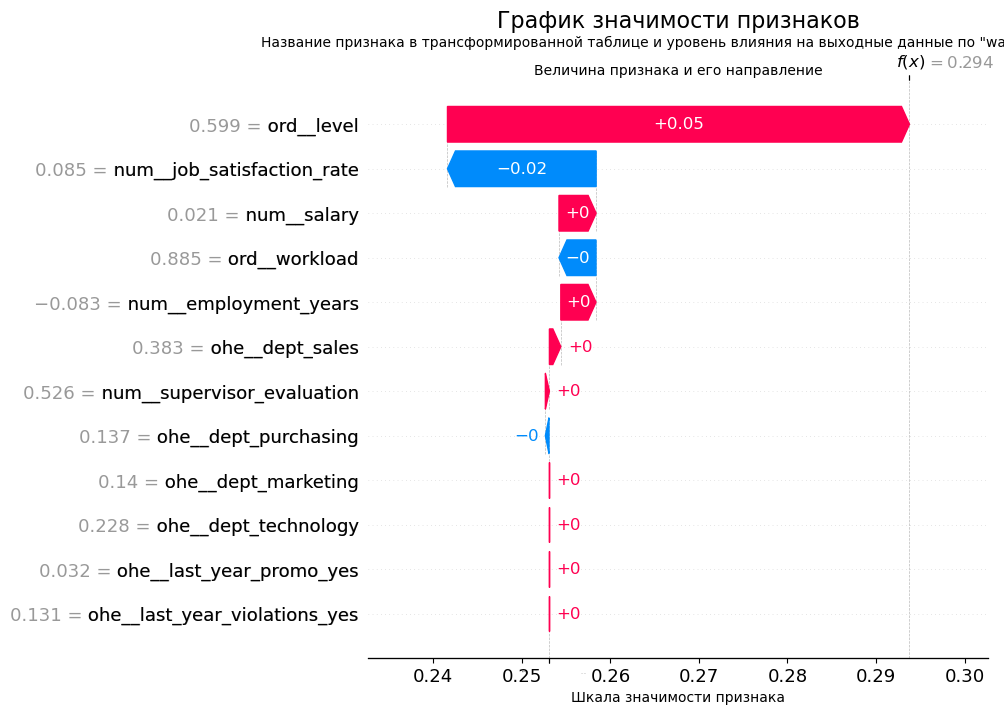

In [99]:
# Получение лучшей модели
best_model = rs.best_estimator_
# Применение преобразований к X_train
X_transformed = pd.DataFrame(data_preprocessor.transform(X_test_2), columns=data_preprocessor.get_feature_names_out())
# Создание explainer с использованием преобразованного X_train
explainer = shap.TreeExplainer(best_model.named_steps['models'])
# Вычисление значений SHAP
shap_values = explainer(X_transformed)

# Визуализация
shap_values_sum = 0
for i in range(1, len(shap_values)):
    shap_values_sum += shap_values[i]
    
shap.plots.waterfall(((shap_values_sum / len(shap_values))[:,1]), max_display=20, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_title('График значимости признаков', fontsize=16)
ax.set_xlabel('Название признака в трансформированной таблице и уровень влияния на выходные данные по "waterfall" SHAP')
ax.set_ylabel('Урые данные модели)', fontsize=14)

cb_ax0 = fig.axes[0] 
cb_ax0.set_xlabel('Шкала значимости признака')

cb_ax1 = fig.axes[1] 
cb_ax1.tick_params( labelsize=0)
cb_ax1.set_xlabel('Величина признака и его направление')

plt.show()


Проверим лучшую модель на соответствие условию: ROC-AUC ≥ 0.91 на тестовой выборке

In [100]:
roc_auc_rs_test = roc_auc_score(y_test_2, rs.predict_proba(X_test_2)[:, 1])
if (roc_auc_rs_test >= 0.91):
    print ('Модель удовлетворяет условию: на тестовой выборке ROC-AUC', round(roc_auc_rs_test, 4), '>= 0.91')
else:
    print('Модель не удовлетворяет условию:  ROC-AUC на тестовой выборке >= 0.91 n\ ТРЕБУЕТСЯ ДОПОЛНИТЕЛЬНОЕ ИССЛЕДОВАНИЕ')

Модель удовлетворяет условию: на тестовой выборке ROC-AUC 0.9234 >= 0.91


**Заключение:** Отобранная модель соответствует условию

In [101]:
dummy_class = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_class.fit(X_train_2, y_train_2)

roc_auc_rs_train = roc_auc_score(y_train_2, rs.predict_proba(X_train_2)[:, 1])
print(f'Значение ROC-AUC лучшей модели на обучающей выборке: {round(roc_auc_rs_train, 4)}')
roc_auc_rs_train = roc_auc_score(y_train_2, dummy_class.predict_proba(X_train_2)[:, 1])
print(f'Значение ROC-AUC модели `DummyClassifier` на обучающей выборке: {round(roc_auc_rs_train, 4)}')
print('----------')
roc_auc_rs_test = roc_auc_score(y_test_2, rs.predict_proba(X_test_2)[:, 1])
print(f'Значение ROC-AUC лучшей модели на тестовой выборке: {round(roc_auc_rs_test, 4)}')
roc_auc_rs_test = roc_auc_score(y_test_2, dummy_class.predict_proba(X_test_2)[:, 1])
print(f'Значение ROC-AUC модели `DummyClassifier` на тестовой выборке: {round(roc_auc_rs_test, 4)}')

Значение ROC-AUC лучшей модели на обучающей выборке: 0.9338
Значение ROC-AUC модели `DummyClassifier` на обучающей выборке: 0.5017
----------
Значение ROC-AUC лучшей модели на тестовой выборке: 0.9234
Значение ROC-AUC модели `DummyClassifier` на тестовой выборке: 0.5013


### 3.7 Выводы

**Промежуточный итог**

В процессе отбора была определена модель DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42), которая удовлетворяет требованию ROC-AUC на тестовой выборке ≥ 0.91. Её показатели составили 0.9234. Параметры данной модели: {'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss'}. Эта модель оказалась лучше в прогнозировании, поскольку она учитывала больше параметров и была менее подвержена влиянию выбросов в данных.

Был построен каскадный объяснитель из библиотеки SHAP, который позволил определить значимые признаки для данной модели:

1. level - уровень занимаемой должности
2. job_satisfaction_rate - уровень удовлетворенности сотрудника работой
3. salary - ежемесячная зарплата сотрудника
4. workload - уровень загруженности сотрудника
5. employment_years - длительность работы в компании

Модель была оценена на адекватность, и её качество по метрике ROC-AUC оказалось значительно выше метрики модели DummyClassifier. Значения ROC-AUC лучшей модели на обучающей выборке составило 0.9338, в то время как значение ROC-AUC модели DummyClassifier на обучающей выборке составило 0.5017.

## 4 Общий вывод

В процессе работы требовалось:
+ оптимизировать управление персоналом и предложить бизнесу, как избежать финансовых потерь из за оттока сотрудников.

Задача решалась в 2 этапа:

1. Построение модели, которая предсказывает уровень удовлетворённости работой в компании
+ Загрузка данных
    + Данные соответствуют описанным
+ Предобработка данных
    + В колонках данные соответствуют типу
    + Дубликаты не обнаружены. 
    + Выявлены пропуски в колонках `dept`и `level`, в колонках train_job_satisfaction_rate['dept'] и test_features['workload'] обнаружены пробелы, проведена замена пробелов `' '` на `np.nan`.
    + исправлена ошибка `sinior` на `senior`
+ Исследовательский анализ данных
    + данные `id`, переведены в индекс, отсортированы по возрастающему 
    + в данных обнаружены выбросы
    + Между входными параметрами отсутствует связь выше 0,9 следовательно при обучении модели учитывать мультиколлинеарность не надо (максимальное значение корреляция phi(k) (учитывает нелинейную зависимость и возвращается к коэффициенту корреляции Пирсона в случае бинарного нормального распределения входных данных) phi(k) = 0,79
    + В колонках `dept`, `level`, `workload` необходимо заменить пропуски, предпочтительно на часто встречающееся
    + Три признака: `dept`, `last_year_promo`, `last_year_violations` — нужно кодировать с помощью OneHotEncoder.
    + Два признака: `level`, `workload` — нужно кодировать с помощью OrdinalEncoder.
    + Три признака: `employment_years`, `supervisor_evaluation`, `salary` - достаточно масштабировать.
+ Подготовка данных
    + Заполнены пропуски
    + Проведено кодирование в соответствии с признаками (использовано два кодировщика `ohe - OneHotEncoder`, `ord - OrdinalEncoder`)
    + Проведено масштабирование данных
+ Обучение моделей
    + Лучшей моделью определена: В процессе работы отобрана лучшая модель: `DecisionTreeRegressor(max_features=9, random_state=42)` с параметрами: `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(max_features=9, random_state=42)}`
    + Качество модели удовлетворяет: ритерию успеха SMAPE ≤ 15 на тестовой выборке: по факту 14.3863
+ Оформление выводов
    + В процессе обучения моделей и подбора параметров работа производилась для: LinearRegression() и  DecisionTreeRegressor()
    + В процессе работы отобрана лучшая модель: `DecisionTreeRegressor(max_depth=14, max_features=9, random_state=42)` с параметрами: `{'preprocessor__num': 'passthrough', 'models__max_features': 9, 'models__max_depth': 14, 'models': DecisionTreeRegressor(max_depth=14, max_features=9, random_state=42)}`
    + В процессе работы отбор модели производился по целевой функции SMAPE (англ. symmetric mean absolute percentage error, "симметричное среднее абсолютное процентное отклонение"). Качество лучшей модели удовлетворяет: Критерию успеха SMAPE ≤ 15 на тестовой выборке: по факту 14.7877
    + Дан ответ на вопрос: "Почему LinearRegression() хуже справилась с поставленной задачей?". Потому что матрица корреляции, явно показала отсутствие явной линейной зависимости между входными и целевыми показателями максимальное значение phi(k) = 0,79 и потому что DecisionTreeRegressor() оперативно подстроилось между входными и целевыми параметрами во время обучениявеньше подвержена влиянию выбросов во входных данных.
    + Отобранная лучшая модель прошла проверку на адекватность
    
2. Построение модели, которая предсказывает увольнение сотрудника из компании
+ Загрузка данных
    + Данные соответствуют описанным
+ Предобработка данных
    + В колонках данные соответствуют типу
    + Дубликаты не обнаружены. 
    + Выявлены пропуски в колонках `dept`и `level`, в колонках `test_features['dept']` и `test_features['workload']` обнаружены пробелы, проведена замена пробелов `' '` на `np.nan`. 
    + исправлена ошибка `sinior` на `senior`    
+ Исследовательский анализ данных
    + Принято решение провести повторное исследование данных так как в таблицах `train_job_satisfaction_rate` и `train_quit` значения в столбцах `id` не совпадают, а заначит данные могут быть разными
    + Составили портрет уволившегося сотрудника: 
        + Начинающий сотрудник (отработал всего год) с вероятностью 53% 
        + Навыки работы - junior с вероятностью 89%
        + Оценен непосредственным руководителем на 3 по 5 бальной шкале с вероятностью 46%
        + Является сотрудником отдела Sales с вероятностью 36%, отдела Technology - 24%
        + Загрузка сотрудника Low с вероятностью 46% и Medium - 43%
        + В течении года нарушал трудовую дисциплину с вероятностью 20%
        + Медианная заработная плата составляет 22800, в то время как продолживших работать 34800
    + Провели сопоставление признаков удовлетворенности работой и увольнением сотрудников. 
        + Построенные гистограммы с боксплотами и плотность распределения удовлетворенности работой, указывает на связь с увольнением сотрудников. В общем случае можно указать, что увольняются работники, которые неудовлетворены работой.
+ Добавление нового входного признака
    + Добавили признак `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи
    + Проверили отсутствие наличия мультиколлениарности в данных
+ Подготовка данных
    + При подготовке данных использовано два кодировщика, осуществлен визуальный контроль подготовки данных в пиплайне.
+ Обучение модели
    + Проведенна настройка и поиск параметров модели в ручном и автоматическом режиме при помощи пиплайнов
    + Определены значимые признаки для лучшей модели `DecisionTreeClassifier` (по убывающей):
        1. level - `+` - уровень занимаемой должности
        2. job_satisfaction_rate - `-` - уровень удовлетворенности сотрудника работой
        3. salary - `+` - ежемесячная зарплата сотрудника
        4. workload - `-` - уровень загруженности сотрудника
        5. employment_years - `+` - длительность работы в компании
+ Овормлен вывод по разделу
    + В процессе отбора определили модель, которая удовлетворяет требованию: ROC-AUC на тестовой выборке ≥ 0.91 , при этом указанный показатель у модели `DecisionTreeClassifier(criterion='log_loss', max_depth=6, max_leaf_nodes=30, min_samples_leaf=3, min_samples_split=7, random_state=42)` = 0.9234. Её параметры `{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss'}`
    + Данная модель лучше справилась с прогнозированием, так как при её построении было перебрано больше параметров и на неё меньше оказывают влияния существующие выбросы в данных.
    + Для указанной модели построен каскадный объяснитель из библиотеки SHAP, по которому определены значимые признаки (по убываюшей):
        1. level - `+` - уровень занимаемой должности
        2. job_satisfaction_rate - `-` - уровень удовлетворенности сотрудника работой
        3. salary - `+` - ежемесячная зарплата сотрудника
        4. workload - `-` - уровень загруженности сотрудника
        5. employment_years - `+` - длительность работы в компании

    + Модель оценена на адекватность, её качество по метрике ROC-AUC значительно превосходит метрику модели `DummyClassifier`
        + Значение ROC-AUC лучшей модели на обучающей выборке: 0.9338
        + Значение ROC-AUC модели `DummyClassifier` на обучающей выборке: 0.5017
   
3. Общий вывод
    + Составлен данный вывод
    

**Рекомендации для бизнеса:**

В целях уменьшения увольнения персонала и сокращения издержек, предлагается:
1. При определении сотрудников склонных к увольнению, продолжить собирать статистику представленную для анализа и анализировать полученные данные разработанным продуктом.

2. Основное направление состредоточить на наиболее значимых признаках, в большей степени влияющих на увольненние сотрудников (значимость по убывающей):

+ `level` - уровень занимаемой должности -  как правило увольняются новички. В данном направлении необходимо указывать работникам перспективы карьерного роста - заинтересовывать новыми направлениями.
+ `job_satisfaction_rate` - уровень удовлетворенности сотрудника работой - в процессе работы определено, что есть зависимость между удовлетворенностью работой и увольнением - возможно провести дополнительное тестирование работников и выяснить, что именно им ненравится в работе - общая идея: выяснить причины неудвлетворенности работой и снизить их влияние
+ `salary` - ежемесячная зарплата сотрудника - из анализа видно, что увольняются работники медианная зарплата которых ниже работников оставшихся работать, но просто поднимать зарплату нельзя. В этом случае нужен индивидуальный подход и точный расчет экономической целесообразности увеличения заработной платы
+ `workload` - уровень загруженности сотрудника, влияет на увольнение, но в большей степени увольняются работники с низкой загруженностью. Возможно увеличить нагрузку на сотрудника и одновременно с этим увеличить заработную плату, тогда такое решение может привести положительный эффект
+ `employment_years` - длительность работы в компании - влияет чем больше сотрудник работает на предприятии, тем меньше вероятность его увольнения. Следует заинтересовавать и стимулировать молодых специалистов имеющих, стаж работы на предприятии менее двух лет.

3. Основное усилие работы изложенные во втором пункте сосредоточить на категории работников наиболее склонных к увольнению:
+ Начинающий сотрудник (отработал всего год) с вероятностью 53% 
+ Навыки работы - junior с вероятностью 89%
+ Оценен непосредственным руководителем на 3 по 5 бальной шкале с вероятностью 46%
+ Является сотрудником отдела Sales с вероятностью 36%, отдела Technology - 24%
+ Загрузка сотрудника Low с вероятностью 46% и Medium - 43%
+ В течении года нарушал трудовую дисциплину с вероятностью 20%
+ Медианная заработная плата составляет 22800, в то время как продолживших работать 34800

**Предлагаемые меры, несомненно приведут к сокращению объема увольнения и издержек, связанных с ними.**